(ch:psf01)=
# PSF Extraction
From the theory lecture, you learned PSF (point spread function) is the shape of the point source in your detector, after passing through all the optics. It includes the diffraction pattern, seeing (natural + telescope), etc. For space telescopes, PSF will be very stable because both the seeing sources will be negligible (if thermal expansion is well suppressed). Only the gradual change due to the degradation of the optics maybe important (or some dramatic changes by dust impact). 

In reality, it is practically impossible to know the PSF a priori for ground-based observations, especially because both the seeing factors are chaotic and impossible to predict. Also, there is absolutely no guarantee that the PSF will be the same for the consecutive images (you may need to include a slowly varying time-variation term, such as that in [Stetson 1987](https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract)) Thus, one must rely on empirical estimation of the PSF of the given image. 

Students living in the 2020s may want to ask the AI to estimate the PSF in the image. However, as in any other branches of science, the current AI technology is not suitable for most of the quantitative analyses (especially because of the error analysis). Thus, classical approach would be 
1. Tell the program a rough FWHM value ("initial guess").
2. Tell the program which shape of PSF you expect (e.g., "use Gaussian fitting", "use Moffat and spline interpolation", etc.).
3. Manually check if the PSF is well estimated (check the "residuals").
4. Manually check if the PSF photometry is done correctly (repeat the processes if necessary).

## Preparation
First, load the data:

In [21]:
from pathlib import Path

import _tool_visualization as vis
import numpy as np
import pandas as pd
import ysfitsutilpy as yfu
import ysphotutilpy as ypu
from astropy.io import fits
from astropy.nddata import CCDData, Cutout2D
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from matplotlib import pyplot as plt
from matplotlib import rcParams
from photutils.aperture import CircularAnnulus as CAn
from photutils.aperture import CircularAperture as CAp
from scipy.interpolate import RectBivariateSpline

plt.style.use('default')
rcParams.update({'font.size':12})
    
DATAPATH = Path("../../Tutorial_Data/")
LOGPATH = Path("./tmp")  # a temporary output directory
LOGPATH.mkdir(exist_ok=True, parents=True)

# Load our data
fpath = DATAPATH/"SNUO_STX16803-M11-1-1-20190507-171622-V-60.0.fits"
ccd_raw = CCDData.read(fpath)

gain = ccd_raw.header.get("GAIN", 1)
rdnoise = ccd_raw.header.get("RDNOISE", 0)

Then, do the cosmic-ray rejection. (see [CR rejection lecture](ch:crrej)) 

* **NOTE**: ``yfu.crrej`` is nothing but ``astroscrappy.detect_cosmics``, with some additional tasks to add history in the FITS files.

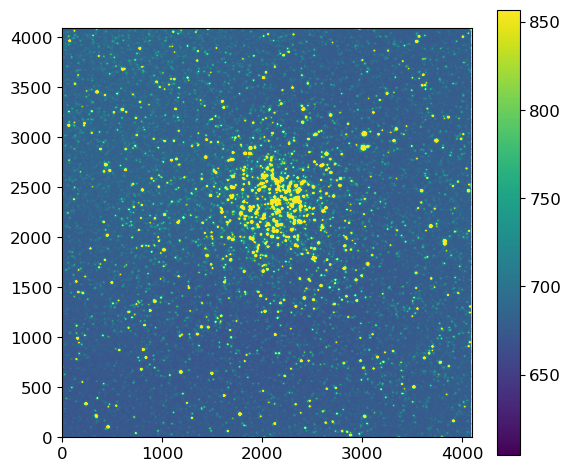

In [22]:
crpath = LOGPATH / "SNUO_STX16803-M11-1-1-20190507-171622-V-60.0_CR.fits"
if crpath.exists():
    ccd = CCDData.read(crpath)
else:
    ccd, crmask = yfu.crrej(
        ccd=ccd_raw,
        gain=gain,
        rdnoise=rdnoise,
        objlim=5.,
        sepmed=True,   # IRAF LACosmic is sepmed=False        
    )
    ccd.write(crpath)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = vis.norm_imshow(ax, ccd.data, zscale=True)
plt.colorbar(im)
plt.tight_layout()

## Initial FWHM
From ginga, you have to find the FWHM of the stars.

1. Open ginga
2. ``Operation`` → ``FBrowser`` → open your FITS file (Here, ``LOGPATH/SNUO_STX16803-M11-1-1-20190507-171622-V-60.0_CR.fits``)
3. ``Operation`` → ``Analysis`` → ``Pick``
4. Find a star that (1) does not overlap with others, (2) is bright enough but not saturated. They are not at the center of the image.
5. left click and right click to do "pick" ([See official documentation of Pick](https://ginga.readthedocs.io/en/stable/manual/plugins_local/pick.html))
6. Bottom right panel: ``Settings`` → set ``Radius`` to 30 pix (since SNUO 1m has too small pixel scale...) && ``FWHM fitting`` to ``Moffat``
7. Click ``Redo Pick``
8. Top right panel: Select ``Radial``.
9. Check if it is good:
![](figs/psfpick.png)
10. If not good, select a different star.
11. Bottom right panel: ``Report`` → ``Add Pick``
12. Do this for around 10 stars throughout the image (better if regularly spaced).
13. ``Save table`` with name ``pick_log.csv``.

## Load the ``Pick`` Results

Load the ginga ``Pick`` results, and find the centers of the stars. 

In [23]:
_pick_log_path = LOGPATH/"pick_log.csv"

# get column names
with open(_pick_log_path, "r") as f:
    pick_colnames = f.readline().strip().split(" ")[1:]  # First one is just `#`
    
pick_log = pd.read_csv(_pick_log_path, names=pick_colnames, sep=" ", comment="#")

# NOTE: ginga pick has 1-indexing: https://github.com/ejeschke/ginga/issues/769
pick_log["x"] -= 1
pick_log["y"] -= 1

# Take sigma-clipped median of FWHM as initial guess
FWHM_INIT = sigma_clipped_stats(pick_log["fwhm"], sigma=3.0, maxiters=5)[1]
PSFSIZE = 2 * int(2 * FWHM_INIT) + 1
print(f"FWHM_INIT = {FWHM_INIT:.2f} pixels")
print(f"PSFSIZE = {PSFSIZE} pixels")

pick_log[["x", "y", "fwhm", "brightness", "background"]]

FWHM_INIT = 12.03 pixels
PSFSIZE = 49 pixels


,x,y,fwhm,brightness,background
0,3863.020138,707.683315,11.962709,756.294478,703.163513
1,3514.125040,500.461007,12.047357,3113.724378,723.208466
2,791.043571,676.635925,12.041618,1806.826784,703.645050
3,238.905269,332.319899,12.026944,3362.454716,721.233795
4,880.530746,1262.908716,11.953833,1600.975989,708.042664
5,450.723343,2016.108091,11.974557,2423.947034,715.987640
6,802.402071,2468.025588,11.724034,2934.561519,698.899902
7,776.520519,3882.919494,11.921826,1851.317307,699.666199
8,1600.434322,3353.373197,11.943629,2051.583265,697.423889
9,3738.857578,2961.212126,12.383431,8053.690733,703.893646


Here, 
* ``fwhm`` is the FWHM from radial profile (you must have chosen radially symmetric objects, not galaxy-like objects)
* ``background`` is the local background level (rough estimate)
* ``brightness`` is the "peak pixel value" - "background".
* ``FWHM_INIT`` is the sigma-clipped median of the FWHM values of the selected point-sources.

From now on, I will set the PSF size to be a box of side length ``PSFSIZE = 4*FWHM_INIT+1`` ~ 49 (usage of `int` is a coding trick. Think about the case of FWHM=0.4 and 0.6 pixel case). This means, when estimating PSF, I extract 49x49 pixels around the center of each star. Therefore, ideally, there should be no overlapping stars or background object in the nearby ~ 25 pixels (~ 49/2).

## Prapare Cutouts for Each Star
Now cut the 49x49 pixels around the stars. Because the central location from ginga pick is not the most accurate, I will
1. Re-calculate the central pixel using [sep](https://github.com/kbarbary/sep).
2.

In [37]:
# Initialize
pick_fit = dict(
    x0=[], y0=[], x=[], y=[], shift=[], fwhm=[], bkg_ginga=[],
    msky=[], ssky=[], nsky=[], nrej=[], aperture_sum=[], aperture_sum_err=[],
    source_sum=[], source_sum_err=[], mag=[], merr=[], snr=[]
)

_aps, _ans = ypu.circ_ap_an(
    np.array([pick_log["x"], pick_log["y"]]).T,
    fwhm=FWHM_INIT, f_ap=2, f_in=4, f_out=6
)
_phot = ypu.apphot_annulus(ccd, _aps, _ans, gain=gain, rdnoise=rdnoise)

for i, row in pick_log.iterrows():
    fwhm = row["fwhm"]
    x0 = row["x"]
    y0 = row["y"]
    x = _phot.at[i, "xcenter"]
    y = _phot.at[i, "ycenter"]
    shift = np.sqrt((x - x0)**2 + (y - y0)**2)
    for k, v in zip(["x0", "y0", "x", "y", "shift", "fwhm", "bkg_ginga"], 
                    [x0, y0, x, y, shift, row["fwhm"], row["background"]]):
        pick_fit[k].append(v)
    for c in list(pick_fit.keys())[7:]:
        pick_fit[c].append(_phot.at[i, c])
    _cut = Cutout2D(ccd.data, (row["x"], row["y"]), PSFSIZE + max(1, int(0.1*PSFSIZE)))
    
pd.DataFrame.from_dict(pick_fit)

/Users/ysbach/Dropbox/github/ysphotutilpy/ysphotutilpy/apphot.py:222: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(_arr/gn + (rd/gn)**2)


,x0,y0,x,y,shift,fwhm,bkg_ginga,msky,ssky,nsky,nrej,aperture_sum,aperture_sum_err,source_sum,source_sum_err,mag,merr,snr
0,3863.020138,707.683315,3863.020138,707.683315,0.0,11.962709,703.163513,681.910672,26.429745,9025,76,1.407565e+06,1055.781385,1.665485e+05,1544.648632,-8.608474,0.010070,107.822922
1,3514.125040,500.461007,3514.125040,500.461007,0.0,12.047357,723.208466,678.218196,25.328658,9074,27,1.892077e+06,1212.820253,6.577803e+05,1624.339993,-10.099824,0.002681,404.952331
2,791.043571,676.635925,791.043571,676.635925,0.0,12.041618,703.645050,675.977868,24.988556,9072,36,1.602266e+06,1121.533295,3.720469e+05,1547.333258,-9.481116,0.004516,240.443907
3,238.905269,332.319899,238.905269,332.319899,0.0,12.026944,721.233795,673.655055,24.562914,9069,27,1.924117e+06,1222.494174,6.981251e+05,1610.127700,-10.164455,0.002504,433.583670
4,880.530746,1262.908716,880.530746,1262.908716,0.0,11.953833,708.042664,680.939568,27.748045,8874,229,1.568629e+06,1110.451876,3.293793e+05,1623.068444,-9.348863,0.005350,202.936203
5,450.723343,2016.108091,450.723343,2016.108091,0.0,11.974557,715.987640,684.951502,25.975406,8867,227,1.730422e+06,1162.784944,4.838710e+05,1606.238556,-9.766446,0.003604,301.244800
6,802.402071,2468.025588,802.402071,2468.025588,0.0,11.724034,698.899902,686.398201,24.979149,9020,79,1.823402e+06,1191.820653,5.742182e+05,1598.744614,-9.952314,0.003023,359.168153
7,776.520519,3882.919494,776.520519,3882.919494,0.0,11.921826,699.666199,689.402322,27.057238,8886,216,1.621077e+06,1127.682585,3.664258e+05,1613.695821,-9.464587,0.004781,227.072414
8,1600.434322,3353.373197,1600.434322,3353.373197,0.0,11.943629,697.423889,686.289995,27.003879,8414,681,1.657278e+06,1139.423719,4.082910e+05,1620.303315,-9.582046,0.004309,251.984292
9,3738.857578,2961.212126,3738.857578,2961.212126,0.0,12.383431,703.893646,681.853887,26.027390,9056,46,2.946660e+06,1498.786713,1.705747e+06,1865.265364,-11.134408,0.001187,914.479313


In [36]:
for k, v in pick_fit.items():
    print(f"{k}: {len(v)}")

x0: 14
y0: 14
x: 14
y: 14
shift: 14
fwhm: 14
bkg_ginga: 168
msky: 0
ssky: 0
nsky: 0
nrej: 0
aperture_sum: 0
aperture_sum_err: 0
source_sum: 0
source_sum_err: 0
mag: 0
merr: 0
snr: 0


In [12]:
ypu.apphot_annulus

<function ysphotutilpy.apphot.apphot_annulus(ccd, aperture, annulus=None, gain='GAIN', rdnoise='RDNOISE', t_exposure=None, exposure_key='EXPTIME', error=None, mask=None, sky_keys=None, sky_min=None, aparea_exact=False, npix_mask_ap=2, verbose=False, pandas=True, **kwargs)>

In [23]:
max(1, int(0.1*PSFSIZE))

4

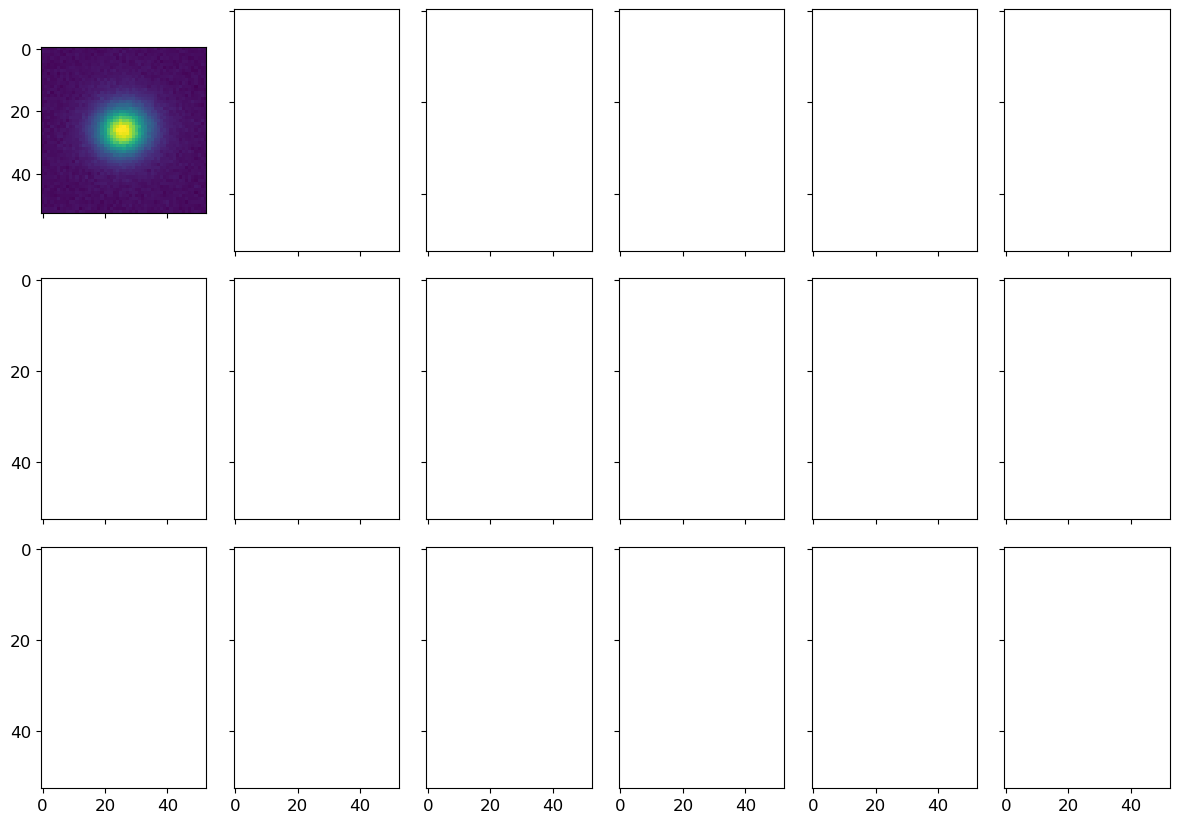

In [22]:
ncol = 6
nrow = max(len(pick_log) // ncol + 1, 1)

fig, axs = plt.subplots(nrow, ncol, figsize=(12, 2.8 * nrow), sharex=True, sharey=True)

#axs[0].
axs[0, 0].imshow(_cut.data)

plt.tight_layout()
plt.show();

In [ ]:

pick = Table.read(, format="ascii.csv", 
                  delimiter=' ', data_start=2, comment="#", names=pick_colnames)
# NOTE: ginga pick has 1-indexing: https://github.com/ejeschke/ginga/issues/769
pick["x"] -= 1
pick["y"] -= 1

# Only pixels near the stars in the txt file
mask = np.ones_like(data).astype(bool)
for row in pick:
    pos = (row["x"], row["y"])
    iy, ix = Cutout2D(mask, position=pos, size=PSFSIZE).bbox_original
    mask[iy[0]:iy[1], ix[0]:ix[1]] = False

thresh = np.median(data)

print("Finding stars...")
finder = DAOStarFinder(fwhm=FWHM_INIT, threshold=thresh, exclude_border=True)
found = finder(data, mask=mask)
print(f"Stars initially selected for the PSF estimation: {len(pick)}")
if len(pick) != len(found):
    print("!!!!!! pick and found length not match !!!!!!")

found.remove_columns(["npix", "sky"]) # remove confusing columns from DAOStarFinder